In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datasets import load_dataset

In [2]:
CATEGORY_MAPPING = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

def load_and_preprocess_data():
    dataset_name = "fancyzhx/ag_news"
    dataset = load_dataset(dataset_name)
    
    train_df = dataset["train"].to_pandas()
    test_df = dataset["test"].to_pandas()
    
    train_df.dropna(subset=['text', 'label'], inplace=True)
    test_df.dropna(subset=['text', 'label'], inplace=True)
    
    train_df['Category'] = train_df['label'].map(CATEGORY_MAPPING)
    test_df['Category'] = test_df['label'].map(CATEGORY_MAPPING)
        
    return train_df, test_df

In [3]:
def build_pipeline(max_features=2000, k_best=1000):
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(lowercase=True, stop_words='english', max_features=max_features)),
        ("select", SelectKBest(score_func=chi2, k=k_best)),
        ("scale", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000, random_state=42))
    ])
    return pipeline

In [4]:
def tune_hyperparameters(pipeline, X_train, y_train):
    param_grid = {
        "clf__C": [0.01, 0.1, 1.0, 10.0],
        "clf__penalty": ['l2']
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best hyperparameters found:", grid_search.best_params_)
    return grid_search.best_estimator_

In [5]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameters found: {'clf__C': 0.01, 'clf__penalty': 'l2'}
=== Test Set Performance ===
Accuracy: 0.8801315789473684
Classification Report:
               precision    recall  f1-score   support

    Business       0.84      0.84      0.84      1900
    Sci/Tech       0.85      0.85      0.85      1900
      Sports       0.93      0.95      0.94      1900
       World       0.89      0.87      0.88      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

=== Cross-Validation on Training Set ===
CV Accuracy Scores: [0.87845833 0.88104167 0.885375   0.88304167 0.88070833]
Mean CV Accuracy: 0.8817 ± 0.0023


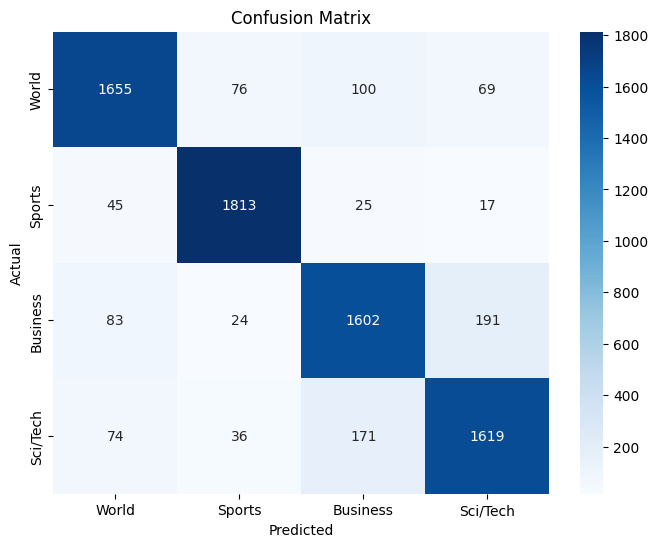

In [6]:
train_df, test_df = load_and_preprocess_data()
X_train = train_df['text'].tolist()
y_train = train_df['Category'].tolist()
X_test = test_df['text'].tolist()
y_test = test_df['Category'].tolist()

pipeline = build_pipeline()
tuned_pipeline = tune_hyperparameters(pipeline, X_train, y_train)
tuned_pipeline.fit(X_train, y_train)

y_pred = tuned_pipeline.predict(X_test)
print("=== Test Set Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Cross-validation on the training set
print("=== Cross-Validation on Training Set ===")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(tuned_pipeline, X_train, y_train, cv=skf, scoring='accuracy')
print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Performance Analysis: Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=list(CATEGORY_MAPPING.values()))